In [3]:
import os
import logging

import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

import sys

sys.path.insert(0, '../')

from original.better_MFF_database import carve_confs
from original import Kernels
from original import GP_for_MFF

logging.basicConfig(level=logging.INFO)

In [4]:

# Parameters
r_cut = 3.5

# GP Parameters
sigma = .6
noise = 0.001


# Construct a configuration database

In [9]:
n_data = 5000
# directory = 'data/ZrO2/test/'
# filename = directory + 'test_monoclinic.xyz'

directory = 'data/ZrO2/train/'
filename = directory + 'train.xyz'

traj = read(filename, index=slice(None), format='extxyz')

elements, confs, forces, energies = carve_confs(traj, r_cut, n_data, USE_ASAP=True)

if not os.path.exists(directory):
    os.makedirs(directory)

np.save('{}/confs_cut={:.2f}.npy'.format(directory, r_cut), confs)
np.save('{}/forces_cut={:.2f}.npy'.format(directory, r_cut), forces)
np.save('{}/energies_cut={:.2f}.npy'.format(directory, r_cut), energies)

lens = [len(conf) for conf in confs]

logging.info('\n'.join((
    'Number of atoms in a configuration:',
    '   maximum: {}'.format(np.max(lens)),
    '   minimum: {}'.format(np.min(lens)),
    '   average: {:.4}'.format(np.mean(lens))
)))


INFO:root:Reading traj step 0
INFO:root:Reading traj step 1
INFO:root:Reading traj step 2
INFO:root:Reading traj step 3
INFO:root:Reading traj step 4
INFO:root:Reading traj step 5
INFO:root:Reading traj step 6
INFO:root:Reading traj step 7
INFO:root:Reading traj step 8
INFO:root:Reading traj step 9
INFO:root:Reading traj step 10
INFO:root:Reading traj step 11
INFO:root:Reading traj step 12
INFO:root:Reading traj step 13
INFO:root:Reading traj step 14
INFO:root:Reading traj step 15
INFO:root:Reading traj step 16
INFO:root:Reading traj step 17
INFO:root:Reading traj step 18
INFO:root:Reading traj step 19
INFO:root:Reading traj step 20
INFO:root:Reading traj step 21
INFO:root:Reading traj step 22
INFO:root:Reading traj step 23
INFO:root:Reading traj step 24
INFO:root:Reading traj step 25
INFO:root:Reading traj step 26
INFO:root:Reading traj step 27
INFO:root:Reading traj step 28
INFO:root:Reading traj step 29
INFO:root:Reading traj step 30
INFO:root:Reading traj step 31
INFO:root:Reading 

INFO:root:Reading traj step 260
INFO:root:Reading traj step 261
INFO:root:Reading traj step 262
INFO:root:Reading traj step 263
INFO:root:Reading traj step 264
INFO:root:Reading traj step 265
INFO:root:Reading traj step 266
INFO:root:Reading traj step 267
INFO:root:Reading traj step 268
INFO:root:Reading traj step 269
INFO:root:Reading traj step 270
INFO:root:Reading traj step 271
INFO:root:Reading traj step 272
INFO:root:Reading traj step 273
INFO:root:Reading traj step 274
INFO:root:Reading traj step 275
INFO:root:Reading traj step 276
INFO:root:Reading traj step 277
INFO:root:Reading traj step 278
INFO:root:Reading traj step 279
INFO:root:Reading traj step 280
INFO:root:Reading traj step 281
INFO:root:Reading traj step 282
INFO:root:Reading traj step 283
INFO:root:Reading traj step 284
INFO:root:Reading traj step 285
INFO:root:Reading traj step 286
INFO:root:Reading traj step 287
INFO:root:Reading traj step 288
INFO:root:Reading traj step 289
INFO:root:Reading traj step 290
INFO:roo

# Check the configurations created

M is 12.54034034034034 += 7.152076360644941


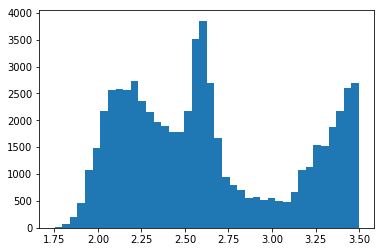

In [10]:

directory = 'data/ZrO2/train/'
filename = directory + 'train.xyz'
confs = np.load(str(directory + 'confs_cut={:.2f}.npy'.format(r_cut)))

distances = []
M_mean = 0.
M_std = 0.
for c in confs:
    distances += np.linalg.norm(c[:, 0:3], axis=1).tolist()
    M_mean += c.shape[0]
    M_std += c.shape[0] ** 2

M_mean = M_mean / len(confs)
M_std = M_std / len(confs) - M_mean ** 2
print('M is {} += {}'.format(M_mean, M_std))
plt.hist(distances, 40)
plt.show()


# Test GP on the built database

In [12]:
# Directories
train_directory = 'data/ZrO2/train/'
test_directory = 'data/ZrO2/test/'

# Parameters
ntr = 50
ntest = 50

print('N train: {}, N test: {}'.format(ntr, ntest))

# Get training configurations and forces from file
tr_confs = np.load(str(train_directory + 'confs_cut={:.2f}.npy'.format(r_cut)))
tr_forces = np.load(str(train_directory + 'forces_cut={:.2f}.npy'.format(r_cut)))
numconfs = len(tr_forces)
ind = np.arange(numconfs)
ind_tot = np.random.choice(ind, size=ntr, replace=False)
tr_confs, tr_forces = tr_confs[ind_tot], tr_forces[ind_tot]

# Get test configurations and forces from file
tst_confs = np.load(str(test_directory + 'confs_cut={:.2f}.npy'.format(r_cut)))
tst_forces = np.load(str(test_directory + 'forces_cut={:.2f}.npy'.format(r_cut)))
numconfs = len(tst_forces)
ind = np.arange(numconfs)
ind_tot = np.random.choice(ind, size=ntest, replace=False)
tst_confs, tst_forces = tst_confs[ind_tot], tst_forces[ind_tot]

ker = Kernels.ThreeBody(theta=[sigma, r_cut / 8.0, r_cut])

gp = GP_for_MFF.GaussianProcess(kernel=ker, noise=noise, optimizer=None)

print('Training GP')

gp.fit(tr_confs, tr_forces)

# Test the GP performance
print('Testing GP')

gp_forces = np.zeros((ntest, 3))
gp_error = np.zeros((ntest, 3))

for i in np.arange(ntest):
    gp_forces[i, :] = gp.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
    gp_error[i, :] = gp_forces[i, :] - tst_forces[i, :]

MAEC = np.mean(abs(gp_error))
MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))
MF = np.mean(np.linalg.norm(tst_forces, axis=1))
RMSE = np.sqrt(np.mean((gp_error) ** 2))

print('RMSE: {:.4}'.format(RMSE))
print('MAEC: {:.4}'.format(MAEC))
print('MAEF : {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))



N train: 50, N test: 50
Started compilation of theano three body kernels
Ended compilation of theano three body kernels
Training GP
Testing GP
RMSE: 1.222
MAEC: 0.9273
MAEF : 1.8554 +- 1.0188
Relative MAEF on forces: 0.9492 +- 0.5212


# Learning curve


Started compilation of theano three body kernels
Ended compilation of theano three body kernels
N train: [20, 40, 80, 160], N test: 30
Training GP
Testing GP
RMSE: 1.029
MAEC: 0.6876
MAEF: 1.3908 +- 1.1135
Relative MAEF on forces: 0.7133 +- 0.5710
Training GP
Testing GP
RMSE: 0.6532
MAEC: 0.4132
MAEF: 0.8132 +- 0.7865
Relative MAEF on forces: 0.5747 +- 0.5559
Training GP
Testing GP
RMSE: 0.5059
MAEC: 0.3245
MAEF: 0.6386 +- 0.6000
Relative MAEF on forces: 0.4850 +- 0.4557
Training GP
Testing GP
RMSE: 0.6835
MAEC: 0.3863
MAEF: 0.7861 +- 0.8853
Relative MAEF on forces: 0.5090 +- 0.5733


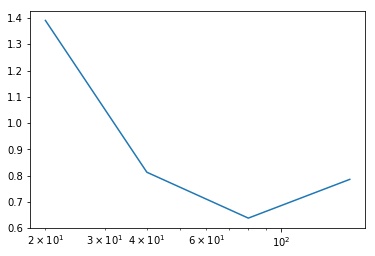

In [14]:
# Directories
train_directory = 'data/ZrO2/train/'
test_directory = 'data/ZrO2/train/'

ker = Kernels.ThreeBody(theta=[sigma, r_cut / 5.0, r_cut])
gp = GP_for_MFF.GaussianProcess(kernel=ker, noise=noise, optimizer=None)

ntrs = [20,40, 80, 160]
ntest = 30
print('N train: {}, N test: {}'.format(ntrs, ntest))
errors = []
np.random.seed(42)

for ntr in ntrs:

    # Get training configurations and forces from file
    tr_confs = np.load(str(train_directory + 'confs_cut={:.2f}.npy'.format(r_cut)))
    tr_forces = np.load(str(train_directory + 'forces_cut={:.2f}.npy'.format(r_cut)))
    numconfs = len(tr_forces)
    ind = np.arange(numconfs)
    ind_tot = np.random.choice(ind, size=ntr, replace=False)
    tr_confs, tr_forces = tr_confs[ind_tot], tr_forces[ind_tot]

    # Get test configurations and forces from file
    tst_confs = np.load(str(test_directory + 'confs_cut={:.2f}.npy'.format(r_cut)))
    tst_forces = np.load(str(test_directory + 'forces_cut={:.2f}.npy'.format(r_cut)))
    numconfs = len(tst_forces)
    ind = np.arange(numconfs)
    ind_tot = np.random.choice(ind, size=ntest, replace=False)
    tst_confs, tst_forces = tst_confs[ind_tot], tst_forces[ind_tot]

    print('Training GP')

    gp.fit(tr_confs, tr_forces)

    # Test the GP performance
    print('Testing GP')

    gp_forces = np.zeros((ntest, 3))
    gp_error = np.zeros((ntest, 3))

    for i in np.arange(ntest):
        gp_forces[i, :] = gp.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
        gp_error[i, :] = gp_forces[i, :] - tst_forces[i, :]

    MAEC = np.mean(abs(gp_error))
    MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
    SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))
    RMSE = np.sqrt(np.mean((gp_error) ** 2))

    MF = np.mean(np.linalg.norm(tst_forces, axis=1))

    print('RMSE: {:.4}'.format(RMSE))
    print('MAEC: {:.4}'.format(MAEC))
    print('MAEF: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
    print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

    errors.append(MAEF)

plt.plot(ntrs, errors)
plt.xscale('log')
plt.show()
